# Linear types analysis

In [92]:
from matplotlib import pyplot as pl
%matplotlib notebook

In [203]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import gmean

In [219]:
def safe_geomean(xs):
    return gmean(xs.dropna())

## `-ddump-timings`

Here we examine the per-module and per-pass timings produced by GHC's `-ddump-timings` output.

In [221]:
from dump_timings_parse import read_timings_log

def read_timings_logs(dir_: Path) -> pd.DataFrame:
    accum = []
    for file in dir_.iterdir():
        name = file.name
        pkg = '-'.join(name.split('-')[:-1])
        log = read_timings_log(file)
        accum.append(log.assign(package=pkg))
        
    return pd.concat(accum)

In [222]:
root = Path('./runs')

d = pd.concat([
    read_timings_logs(run / 'logs').assign(run=run.name)
    for run in root.glob('*')
])

In [223]:
d

pass                     module       alloc     time  \
0                Parser  Diagrams.Solve.Polynomial   6835880.0    3.634   
1   Renamer/typechecker  Diagrams.Solve.Polynomial  76674264.0  125.374   
2               Desugar  Diagrams.Solve.Polynomial   7255384.0    9.412   
3            Simplifier  Diagrams.Solve.Polynomial  96574008.0   85.894   
4            Specialise  Diagrams.Solve.Polynomial   3018632.0    1.579   
..                  ...                        ...         ...      ...   
49             CoreTidy         System.IO.CodePage    843848.0    0.732   
50             CorePrep         System.IO.CodePage     20232.0    0.022   
51              CodeGen         System.IO.CodePage  28696104.0   25.221   
52             CorePrep         System.IO.CodePage     20232.0    0.031   
53              CodeGen         System.IO.CodePage  29966296.0   24.783   

                 package           run  
0   diagrams-solve-0.1.2  master-noopt  
1   diagrams-solve-0.1.2  master-noopt  
2   diagrams-solve-0.1.2  master-noopt  
3   diagrams-solve-0.1.2  master-noopt  
4   diagrams-solve-0.1.2  master-noopt  
..                   ...           ...  
49         code-page-0.2    master-opt  
50         code-page-0.2    master-opt  
51         code-page-0.2    master-opt  
52         code-page-0.2    master-opt  
53         code-page-0.2    master-opt  

[125232 rows x 6 columns]

In [224]:
pd.isna(d['alloc']).any()

False

In [226]:
delta = d.groupby(['run', 'package', 'module']).sum().unstack('run')
delta

alloc                \
run                                           linear-noopt    linear-opt   
package      module                                                        
Glob-0.10.0  System.FilePath.Glob             4.385464e+06  4.385464e+06   
             System.FilePath.Glob.Base        1.856115e+09  1.856115e+09   
             System.FilePath.Glob.Directory   6.930372e+08  6.930372e+08   
             System.FilePath.Glob.Match       3.514852e+08  3.514852e+08   
             System.FilePath.Glob.Primitive   2.803628e+07  2.803628e+07   
...                                                    ...           ...   
zlib-0.6.2.1 Codec.Compression.GZip           1.712033e+07  1.712033e+07   
             Codec.Compression.Zlib           1.697828e+07  1.697828e+07   
             Codec.Compression.Zlib.Internal  1.989760e+09  1.989760e+09   
             Codec.Compression.Zlib.Raw       1.649326e+07  1.649326e+07   
             Codec.Compression.Zlib.Stream    2.732801e+09  2.732801e+09   

                                                                          \
run                                           master-noopt    master-opt   
package      module                                                        
Glob-0.10.0  System.FilePath.Glob             4.386000e+06  4.386000e+06   
             System.FilePath.Glob.Base        1.833563e+09  1.833563e+09   
             System.FilePath.Glob.Directory   6.806087e+08  6.806087e+08   
             System.FilePath.Glob.Match       3.469600e+08  3.469600e+08   
             System.FilePath.Glob.Primitive   2.775138e+07  2.775138e+07   
...                                                    ...           ...   
zlib-0.6.2.1 Codec.Compression.GZip           1.707933e+07  1.707933e+07   
             Codec.Compression.Zlib           1.694009e+07  1.694009e+07   
             Codec.Compression.Zlib.Internal  1.976449e+09  1.976449e+09   
             Codec.Compression.Zlib.Raw       1.645136e+07  1.645136e+07   
             Codec.Compression.Zlib.Stream    2.705195e+09  2.705195e+09   

                                                     time             \
run                                          linear-noopt linear-opt   
package      module                                                    
Glob-0.10.0  System.FilePath.Glob                   2.885      2.885   
             System.FilePath.Glob.Base           1820.161   1820.161   
             System.FilePath.Glob.Directory       547.661    547.661   
             System.FilePath.Glob.Match           363.700    363.700   
             System.FilePath.Glob.Primitive        30.623     30.623   
...                                                   ...        ...   
zlib-0.6.2.1 Codec.Compression.GZip                12.387     12.387   
             Codec.Compression.Zlib                12.630     12.630   
             Codec.Compression.Zlib.Internal     1798.122   1798.122   
             Codec.Compression.Zlib.Raw            12.347     12.347   
             Codec.Compression.Zlib.Stream       2697.644   2697.644   

                                                                      
run                                          master-noopt master-opt  
package      module                                                   
Glob-0.10.0  System.FilePath.Glob                   3.069      3.069  
             System.FilePath.Glob.Base           1855.298   1855.298  
             System.FilePath.Glob.Directory       698.954    698.954  
             System.FilePath.Glob.Match           304.735    304.735  
             System.FilePath.Glob.Primitive        23.761     23.761  
...                                                   ...        ...  
zlib-0.6.2.1 Codec.Compression.GZip                14.474     14.474  
             Codec.Compression.Zlib                12.657     12.657  
             Codec.Compression.Zlib.Internal     1779.164   1779.164  
             Codec.Compression.Zlib.Raw            12.442     

In [251]:
def hist_dump_timing(config, metric, **kwargs):
    pl.figure()
    pl.suptitle(metric)
    rel = (delta[metric][f'linear-{config}'] / delta[metric][f'master-{config}']) * 100
    (rel-100).hist(**kwargs)
    pl.yscale('linear')
    pl.xlabel(f'Relative percent change in {metric}')
    pl.ylabel('number of occurrences')
    print(f'{metric}: mean={rel.mean()}, geomean={safe_geomean(rel)}')

<IPython.core.display.Javascript object>


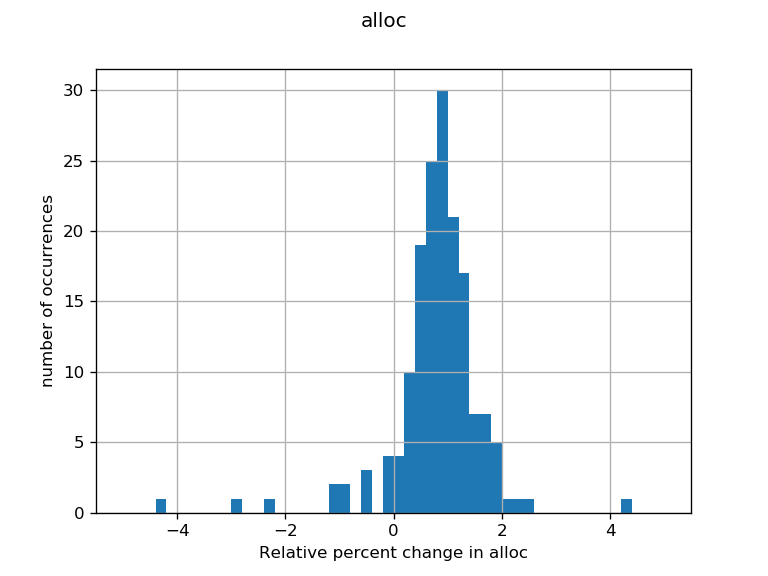

alloc: mean=100.81558180082276, geomean=100.80841378707134


In [254]:
hist_dump_timing('noopt', 'alloc', bins=50, range=(-5,5))

<IPython.core.display.Javascript object>


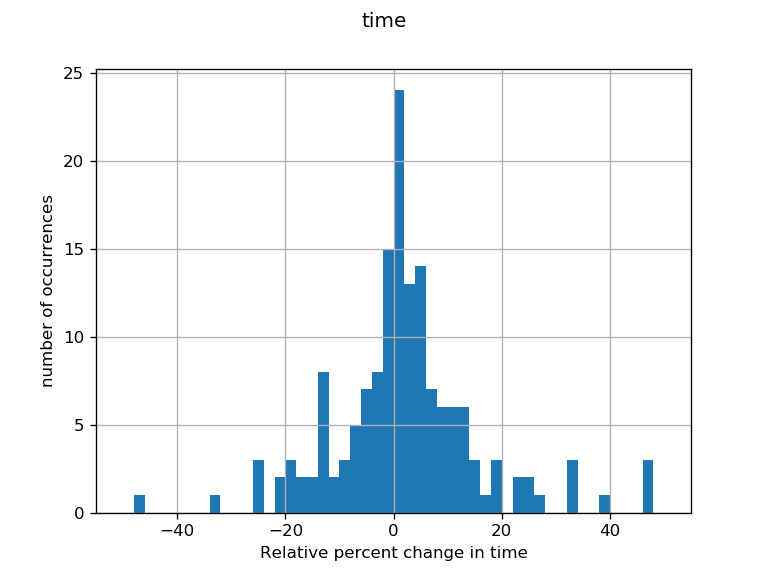

time: mean=106.07975837945718, geomean=104.19888496710423


In [255]:
hist_dump_timing('noopt', 'time', bins=50, range=(-50,50))

<IPython.core.display.Javascript object>


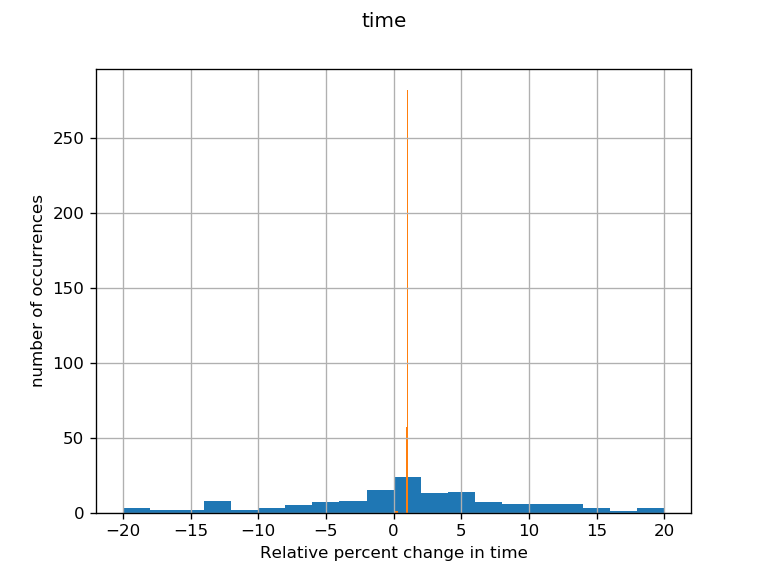

time: mean=106.07975837945718, geomean=104.19888496710423


In [261]:
hist_dump_timing('noopt', 'time', bins=20, range=(-20,20))

In [110]:
delta[rel > 50]

Empty DataFrame
Columns: [(alloc, linear-noopt), (alloc, linear-opt), (alloc, master-noopt), (alloc, master-opt), (time, linear-noopt), (time, linear-opt), (time, master-noopt), (time, master-opt)]
Index: []

## RTS statistics

Here we are looking at the statistics produced by GHC's runtime system.

In [234]:
def read_rts_stats(f: Path) -> pd.DataFrame:
    import ast
    s = f.read_text().strip()
    s = ''.join(s.split('\n')[1:]).strip()
    try:
        out = pd.DataFrame([(k, float(v)) for k,v in ast.literal_eval(s)],
                           columns = ['metric', 'value'])
    except Exception as exc:
        print(f'error: {f}: {exc}')
        return pd.DataFrame([], columns = ['metric', 'value'])
    
    pkg_name = '-'.join(f.name.split('-')[:-2])
    return out.assign(pkg_name=pkg_name)

def read_all_rts_stats(d: Path) -> pd.DataFrame:
    return pd.concat(
        (read_rts_stats(f) for f in d.iterdir()), 
        sort=True)

In [235]:
rts = pd.concat([
    read_all_rts_stats(Path(r / 'rts-stats')).assign(run=r.name)
    for r in root.glob('*')
])

rts

error: runs/master-noopt/rts-stats/tagsoup-0.14.8-8eaf39196dcf9215c8cf6b74671112a10dfef464aa7160d2e30ab9539a02938f.stats: unexpected EOF while parsing (<unknown>, line 0)
error: runs/linear-opt/rts-stats/tagsoup-0.14.8-fbd13720d8955768776d22b18815f605dc1278518a13d19b5556c937542bce0b.stats: unexpected EOF while parsing (<unknown>, line 0)
error: runs/linear-noopt/rts-stats/tagsoup-0.14.8-fbd13720d8955768776d22b18815f605dc1278518a13d19b5556c937542bce0b.stats: unexpected EOF while parsing (<unknown>, line 0)
error: runs/master-opt/rts-stats/tagsoup-0.14.8-8eaf39196dcf9215c8cf6b74671112a10dfef464aa7160d2e30ab9539a02938f.stats: unexpected EOF while parsing (<unknown>, line 0)


metric        pkg_name         value           run
0           bytes allocated         cassava  2.221336e+10  master-noopt
1                   num_GCs         cassava  9.130000e+02  master-noopt
2        average_bytes_used         cassava  6.450639e+07  master-noopt
3            max_bytes_used         cassava  2.345482e+08  master-noopt
4    num_byte_usage_samples         cassava  1.500000e+01  master-noopt
..                      ...             ...           ...           ...
72       gen_1_wall_seconds  process-extras  2.056780e-01    master-opt
73  gen_1_max_pause_seconds  process-extras  6.263300e-02    master-opt
74  gen_1_avg_pause_seconds  process-extras  2.285300e-02    master-opt
75          gen_1_sync_spin  process-extras  0.000000e+00    master-opt
76         gen_1_sync_yield  process-extras  0.000000e+00    master-opt

[109186 rows x 4 columns]

In [236]:
# Number of built packages
rts.groupby(['run'])['pkg_name'].unique().apply(len)

run
linear-noopt    340
linear-opt      340
master-noopt    343
master-opt      343
Name: pkg_name, dtype: int64

In [237]:
def hist_rts_stat(metric: str, new, base, label, range=None, **kwargs):
    deltas = rts.groupby(['metric', 'pkg_name', 'run']).sum().unstack('run').loc[metric]['value']
    rel = (deltas[new] / deltas[base]) * 100
    (rel-100).hist(range=range, label=label, **kwargs)
    #pl.axvline(x=rel.mean(), label=f'{label} (mean)', c='k')
    print(f'{label}: mean={rel.mean()}, geomean={safe_geomean(rel)}')
    pl.suptitle(metric)
    pl.xlabel(f'percent change in {metric}')
    pl.ylabel(f'number of occurrences')
    
def hist_rts_stats(metric: str, **kwargs):
    pl.figure()
    hist_rts_stat(metric, new='linear-opt',   base='master-opt', label='-O1', **kwargs)
    hist_rts_stat(metric, new='linear-noopt', base='master-noopt', label='-O0', **kwargs)
    pl.legend()

<IPython.core.display.Javascript object>


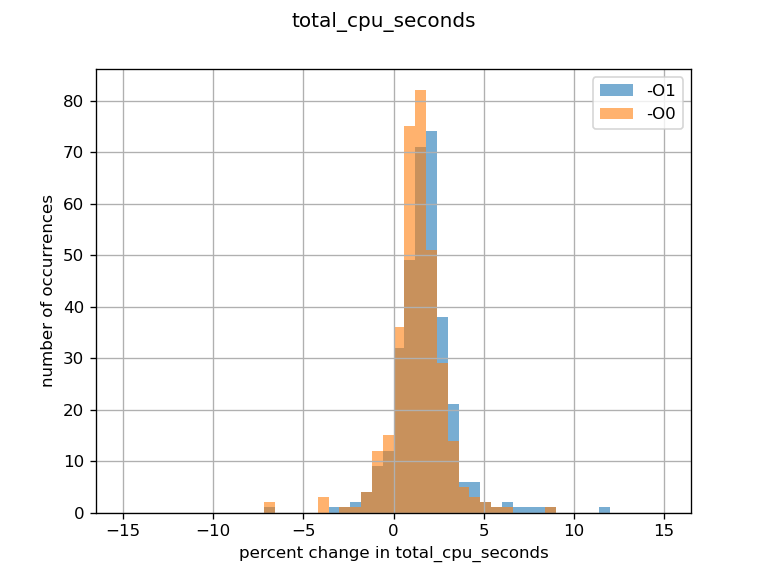

-O1: mean=101.26669511387956, geomean=100.73225362065232
-O0: mean=100.84540978052208, geomean=100.31845456474214


In [238]:
hist_rts_stats('total_cpu_seconds', bins=50, alpha=0.6, range=(-15,15))

<IPython.core.display.Javascript object>


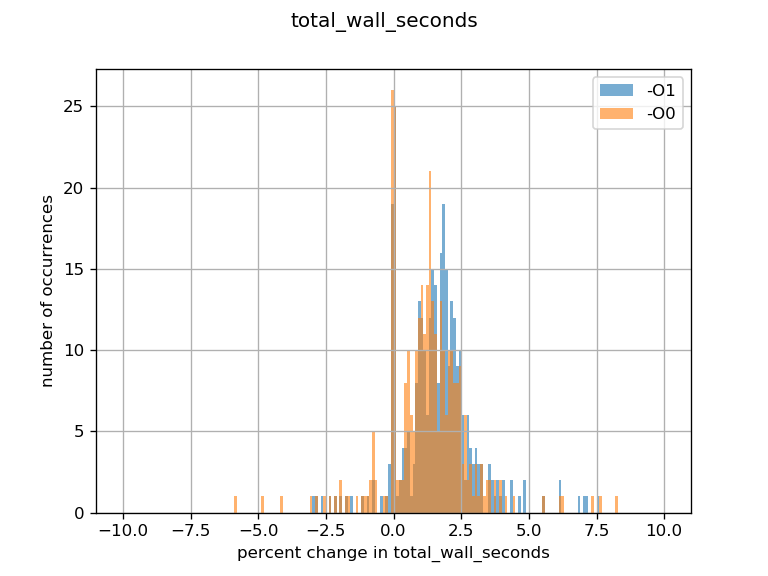

-O1: mean=101.14461939339594, geomean=100.63403281707595
-O0: mean=100.78458512610388, geomean=100.27309597976416


In [243]:
hist_rts_stats('total_wall_seconds', bins=200, alpha=0.6, range=(-10,10))

<IPython.core.display.Javascript object>


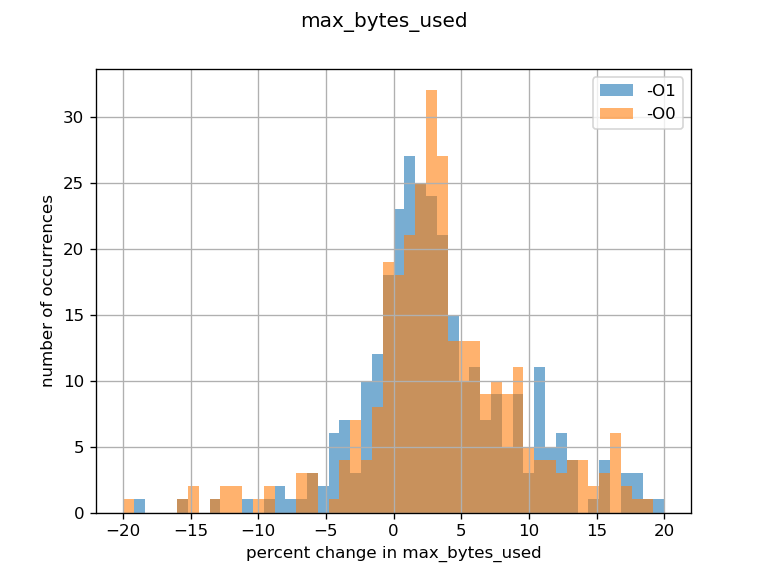

-O1: mean=105.92948512585544, geomean=104.83334088211264
-O0: mean=105.18076172962745, geomean=104.21363044460307


In [239]:
hist_rts_stats('max_bytes_used', bins=50, alpha=0.6, range=(-20,20))

<IPython.core.display.Javascript object>


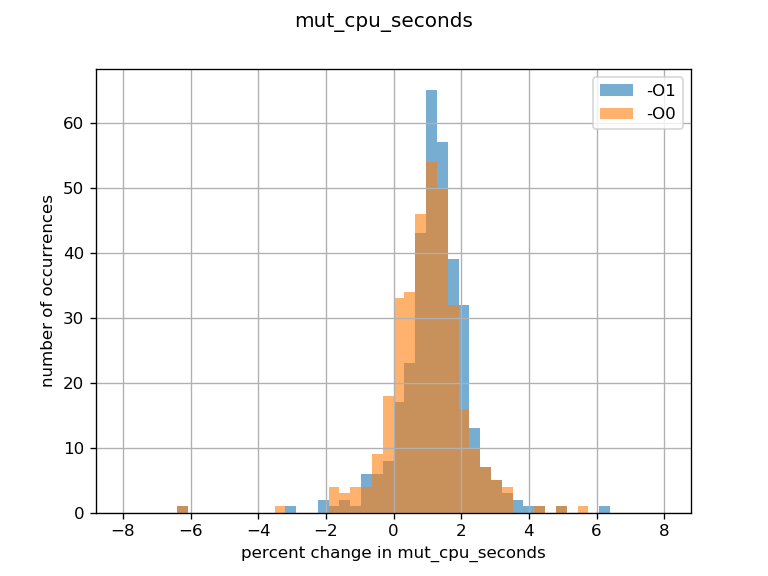

-O1: mean=100.7346486006515, geomean=100.2074456969064
-O0: mean=100.49700347222998, geomean=99.97007311114105


In [246]:
hist_rts_stats('mut_cpu_seconds', bins=50, alpha=0.6, range=(-8,8))

<IPython.core.display.Javascript object>


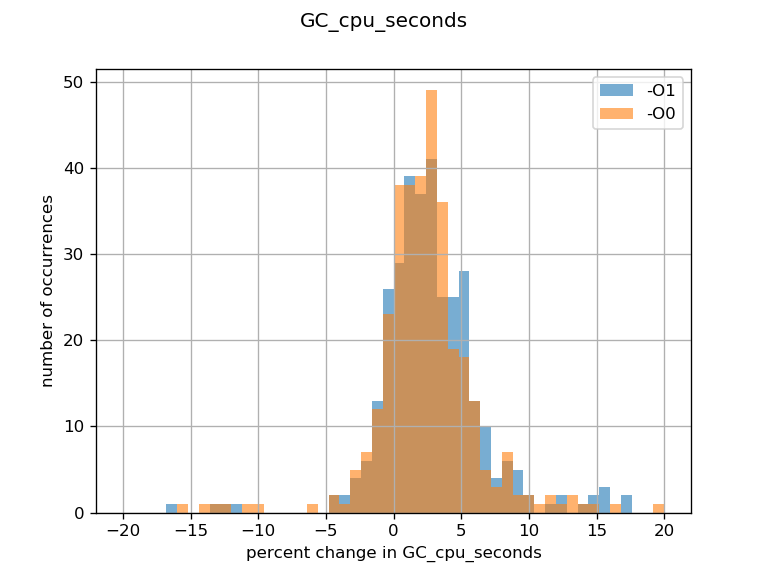

-O1: mean=102.67769041480871, geomean=102.06994529091307
-O0: mean=102.0586413920058, geomean=101.47234487343901


In [244]:
hist_rts_stats('GC_cpu_seconds', bins=50, alpha=0.6, range=(-20,20))

In [240]:
sorted(rts['metric'].unique())

['GC_cpu_seconds',
 'GC_wall_seconds',
 'alloc_rate',
 'allocated_bytes',
 'any_work',
 'average_bytes_used',
 'bound_task_count',
 'bytes allocated',
 'copied_bytes',
 'cumulative_live_bytes',
 'cumulative_par_balanced_copied_bytes',
 'cumulative_par_max_copied_bytes',
 'exit_cpu_seconds',
 'exit_wall_seconds',
 'fragmentation_bytes',
 'gc_alloc_block_sync_spin',
 'gc_alloc_block_sync_yield',
 'gc_spin_spin',
 'gc_spin_yield',
 'gen_0_avg_pause_seconds',
 'gen_0_collections',
 'gen_0_cpu_seconds',
 'gen_0_max_pause_seconds',
 'gen_0_par_collections',
 'gen_0_sync_spin',
 'gen_0_sync_yield',
 'gen_0_wall_seconds',
 'gen_1_avg_pause_seconds',
 'gen_1_collections',
 'gen_1_cpu_seconds',
 'gen_1_max_pause_seconds',
 'gen_1_par_collections',
 'gen_1_sync_spin',
 'gen_1_sync_yield',
 'gen_1_wall_seconds',
 'init_cpu_seconds',
 'init_wall_seconds',
 'major_gcs',
 'max_bytes_used',
 'max_compact_bytes',
 'max_large_objects_bytes',
 'max_live_bytes',
 'max_mem_in_use_bytes',
 'max_slop_bytes',

In [241]:
summary = rts.groupby(['metric', 'pkg_name', 'run']).sum().unstack('run').loc['total_wall_seconds']['value']
summary

run          linear-noopt  linear-opt  master-noopt  master-opt
pkg_name                                                       
Cabal          219.770653  220.140645    215.930651  216.370633
Decimal          1.700276    1.450243      1.420232    1.420235
EdisonAPI        1.400266    1.400294      1.370258    1.360255
EdisonCore      27.170327   27.080330     26.730309   26.600301
FPretty          0.530262    0.530261      0.520268    0.520271
...                   ...         ...           ...         ...
xml-types        5.270296    5.280276      5.190255    5.170283
yaml             8.450369    8.450328      8.450312    8.330329
yesod-core      22.990455   22.960456     22.580476   22.550444
zip-archive      4.910316    4.890290      4.810272    4.800300
zlib             4.740272    4.700282      4.680259    4.640268

[343 rows x 4 columns]

In [242]:
summary[summary['linear-noopt'] > 15]

run                      linear-noopt  linear-opt  master-noopt  master-opt
pkg_name                                                                   
Cabal                      219.770653  220.140645    215.930651  216.370633
EdisonCore                  27.170327   27.080330     26.730309   26.600301
HsYAML                      20.390296   20.260283     20.200272   20.110271
JuicyPixels                140.290327  140.870325    139.650313  138.350391
ListLike                    33.670327   33.670321     32.910293   32.820340
QuickCheck                  32.510532   32.570598     32.290969   32.270660
SHA                         22.940304   22.840268     22.640269   22.450284
aeson                      204.440762  205.070726    202.380706  201.260715
aivika                      54.910474   55.050436     54.270423   53.720398
aivika-transformers         71.640477   71.610476     70.900487   70.290505
attoparsec                  25.980297   25.910303     26.150308   25.950300
basement                    30.110365   30.150370     29.700359   29.750351
blaze-html                  15.370279   15.450294     15.160295   15.170304
bytes                       18.490650   18.470655     18.340611   18.420633
cassava                     20.130323   20.100312     19.710344   19.650341
combinat                    25.970332   26.060347     25.370356   25.500349
cql                         35.500319   35.190364     35.220399   34.990311
criterion                   23.800363   23.740369     23.530427   23.350389
cryptonite                  38.570524   38.590460     38.500463   38.180528
deriving-compat             27.830616   27.740671     27.450841   27.370603
diagrams-lib                34.800500   34.830432     34.620441   34.360446
ersatz                      22.360318   22.460300     22.290417   22.220337
fixed-vector                25.090311   24.940282     25.350272   25.140298
foundation                  28.250379   28.230400     27.810403   27.800424
free                        15.550351   15.630370     15.140344   15.170344
generic-deriving            21.120310   21.120309     21.030299   20.720308
generics-sop                27.330284   27.410376     26.960302   26.810312
hgeometry                   69.160517   68.790520     68.990499   68.520508
hgeometry-combinatorial     26.630440   26.570432     25.950397   25.770443
hmatrix                     86.400306   87.570352     85.700321   85.520323
http2                       15.500360   15.420344     15.240336   15.110402
hxt                         51.190429   51.110441     50.370436   50.250444
lens                       137.960925  138.160964    135.921018  135.660964
linear                      51.610350   52.120373     51.200362   50.760442
mono-traversable            34.670296   34.750292     34.310339   34.710307
mwc-random                  23.120253   23.160291     22.990262   23.040313
optics-core                 16.840669   16.920361     16.640335   16.590352
pandoc-types                28.460300   28.510635     27.320288   27.400304
parameterized-utils         17.141443   17.210487     16.920549   17.040540
persistent                  34.280396   34.140391     33.870402   33.950394
plots                       29.900407   29.870397     29.290397   29.270365
shakespeare                 27.490342   27.570325     27.180322   27.080358
singletons                  49.301414   49.300790    317.270766  315.870778
statistics                  90.390386   90.920393     89.130352   88.920352
texmath                     88.880311   89.760298     87.900280   87.640302
text-show                   60.670345   60.660396     59.820421   59.730382
text-show-instances         33.880367   34.020412     34.180366   34.260367
th-desugar                  45.520665   45.540676     44.280666   44.310665
unordered-containers        24.130555   24.230628     23.670566   23.510558
vector                      92.990304   92.770294     92.430305   92.330283
vector-algorithms           22.340284   22.26031

## Perf counters

In [272]:
def read_perf_stats(f: Path) -> pd.DataFrame:
    out = pd.read_csv(f, delimiter=',', comment='#', header=0, names=['value','metric'], usecols=[0,2])
    pkg_name = '-'.join(f.name.split('-')[:-2])
    return out.assign(pkg_name=pkg_name)

def read_all_perf_stats(d: Path) -> pd.DataFrame:
    return pd.concat(
        (read_perf_stats(f) for f in d.iterdir()), 
        sort=True)

perf = pd.concat([
    read_all_perf_stats(Path(r / 'perf-stats')).assign(run=r.name)
    for r in root.glob('*')
], sort=False)
perf

metric    pkg_name         value           run
0   instructions:u      mmorph    4039425232  master-noopt
1   cache-misses:u      mmorph      55694572  master-noopt
0   instructions:u      aivika  175645681541  master-noopt
1   cache-misses:u      aivika    2952887917  master-noopt
0   instructions:u      errors    4890051326  master-noopt
..             ...         ...           ...           ...
1   cache-misses:u      setenv       4607361    master-opt
0   instructions:u  store-core    5223948592    master-opt
1   cache-misses:u  store-core      72804199    master-opt
0   instructions:u  xml-hamlet   28857785212    master-opt
1   cache-misses:u  xml-hamlet     447021583    master-opt

[2844 rows x 4 columns]

In [282]:
d = perf.groupby(['metric', 'pkg_name', 'run']).sum().unstack('run')['value']
d

run                         linear-noopt    linear-opt  master-noopt  \
metric         pkg_name                                                
cache-misses:u Cabal        1.222568e+10  1.210958e+10  1.164775e+10   
               Decimal      7.842524e+07  7.815523e+07  7.639472e+07   
               EdisonAPI    8.755958e+07  8.686090e+07  8.502472e+07   
               EdisonCore   1.590023e+09  1.575727e+09  1.549839e+09   
               FPretty      2.752273e+07  2.734874e+07  2.673628e+07   
...                                  ...           ...           ...   
instructions:u xml-types    1.782876e+10  1.780085e+10  1.753842e+10   
               yaml         2.781344e+10  2.780392e+10  2.774641e+10   
               yesod-core   7.406856e+10  7.391510e+10  7.237622e+10   
               zip-archive  1.672456e+10  1.662500e+10  1.634545e+10   
               zlib         1.673711e+10  1.640492e+10  1.651826e+10   

run                           master-opt  
metric         pkg_name                   
cache-misses:u Cabal        1.176425e+10  
               Decimal      7.560337e+07  
               EdisonAPI    8.499230e+07  
               EdisonCore   1.552213e+09  
               FPretty      2.656578e+07  
...                                  ...  
instructions:u xml-types    1.755227e+10  
               yaml         2.752433e+10  
               yesod-core   7.224965e+10  
               zip-archive  1.640782e+10  
               zlib         1.647975e+10  

[688 rows x 4 columns]

<IPython.core.display.Javascript object>


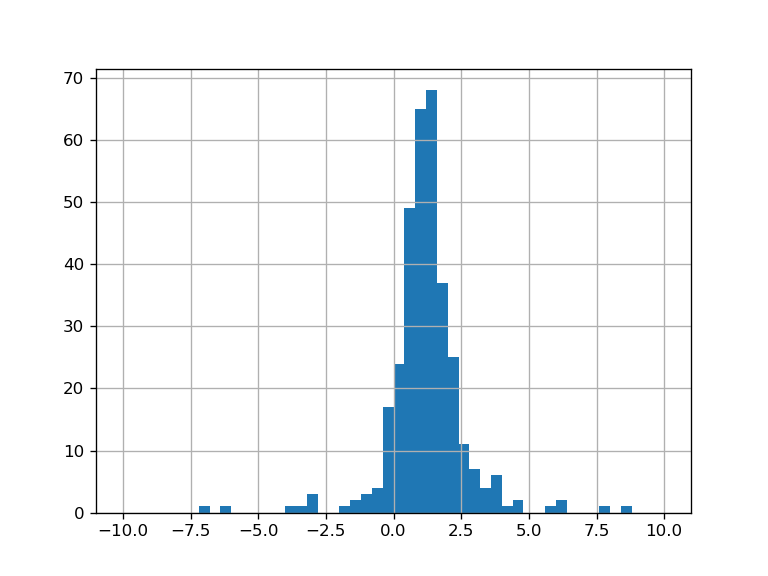

In [294]:
pl.figure()
rel = (d['linear-noopt'] / d['master-noopt'])
(100*rel - 100).loc['instructions:u'].hist(bins=50, range=(-10,10))